In [3]:
#!pip install geopandas 
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, Point
from shapely import wkt
from geopandas import GeoSeries

In [4]:
def readPolygonFromFile(filename):
  with open(filename) as f:
      str = [word for line in f for word in line.split(", ")]
  
  geom = []
  for i in range(len(str)):
      lon, lat = str[i].split(" ")
      geom.append((float(lon), float(lat)))
  p1 = Polygon(geom)
  poly_gdf = gpd.GeoDataFrame(geometry = [p1], crs = "EPSG:3346")
  return poly_gdf

In [5]:
exteriorLine = readPolygonFromFile("kaunas.txt")
exteriorLineScaled = exteriorLine.to_crs(epsg=4326)

In [6]:
# importing economiic data file
geo_data = gpd.read_file('100eco/grid100.shp')
geo_data = geo_data.to_crs(epsg=4326)

geo_data_eco = geo_data[geo_data.metai == 2021]

In [7]:
# importing population data file
geo_data = gpd.read_file('100pop/grid100.shp')
geo_data_pop = geo_data.to_crs(epsg=4326)

In [8]:
# merging datasets
geo_data_pop = geo_data_pop.rename(columns={'GRID_ID': 'grid_id', 'POP': 'pop'})
geo_data_merged = geo_data_eco.merge(geo_data_pop, on='grid_id', how='outer')
geo_data_merged['a'] = geo_data_merged['a'].fillna(0)
geo_data_merged['b_c_d_e'] = geo_data_merged['b_c_d_e'].fillna(0)
geo_data_merged['f'] = geo_data_merged['f'].fillna(0)
geo_data_merged['g_h_i'] = geo_data_merged['g_h_i'].fillna(0)
geo_data_merged['pop'] = geo_data_merged['pop'].fillna(0)

In [60]:
# Z-Score Normalization
def linearNormalize(dataset):
    print(dataset.head())
    print("min", dataset.min())
    print("max", dataset.max())
    return (dataset-dataset.min())/ (dataset.max() - dataset.min())

def zNormalize(dataset):
    return (((dataset - dataset.mean()) / dataset.std()) + 1) / 2

def meanNormalize(dataset1, dataset2):
    return (dataset1 + dataset2) / 2

In [34]:
def getColor(val):
    red = int(255*(1 - max(min(val, 1),0)))
    green = int(255*max(min(val, 1),0))
    #print("c", val, red, green)
    color = '#%02x%02x%02x' % (red, green, 0)
    #print(color)
    return color

def drawRectangle(x, y, val):
    return matplotlib.patches.Rectangle((x, y), 0.00159, 0.00004, color=getColor(val)+'33')

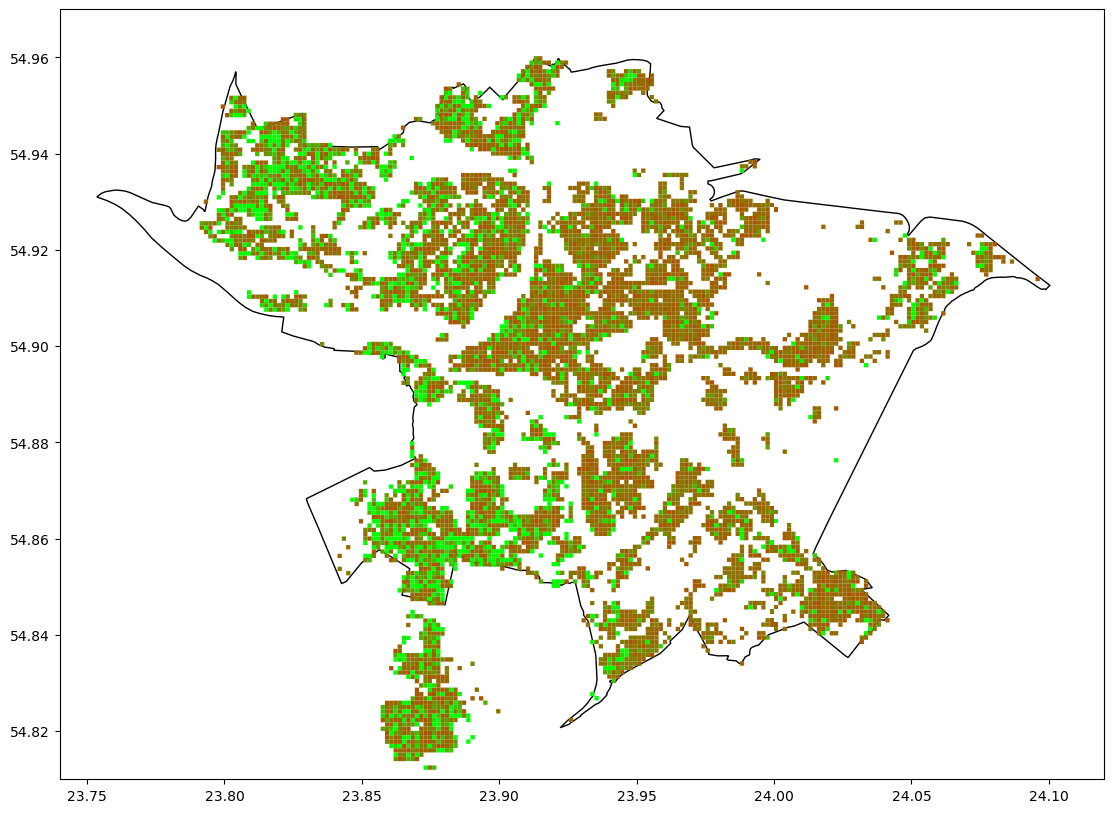

Text(0.5, 0.98, 'Relevant economic sectors')

In [61]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(1,1)

# initialise a dataframe with the right amount of rows
geo_data_merged['eco_normalised'] = geo_data_merged['a']
geo_data_merged['pop_normalised'] = geo_data_merged['a']

plt.ylim((54.81, 54.97))
plt.xlim((23.74, 24.12))

exteriorLineScaled.plot(ax = ax, facecolor="none", edgecolor="black")

for index, row in geo_data_merged.iterrows():
    geo_data_merged.at[index,'eco_normalised'] = int(row['a']) + int(row['b_c_d_e']) + int(row['f']) + int(row['g_h_i'])

geo_data_merged['eco_normalised'] = zNormalize(geo_data_merged['eco_normalised'])
geo_data_merged['pop_normalised'] = zNormalize(geo_data_merged['pop'])
geo_data_merged['normalised'] = meanNormalize(geo_data_merged['eco_normalised'], geo_data_merged['pop_normalised'])

geo_data_merged['color'] = geo_data_merged['normalised'].apply(getColor)

#print(geo_data_merged.head())
geo_data_merged_gdf = gpd.GeoDataFrame(geo_data_merged, geometry='geometry_y')

geo_data_merged_gdf.plot(facecolor=geo_data_merged_gdf.color, ax=ax)
plt.show()

fig.suptitle('Relevant economic sectors')

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(1,1)

# initialise a dataframe with the right amount of rows
geo_data_merged['eco_normalised'] = geo_data_merged['a']

plt.ylim((54.81, 54.97))
plt.xlim((23.74, 24.12))

exteriorLineScaled.plot(ax = ax, facecolor="none", edgecolor="black")

for index, row in geo_data_merged.iterrows():
    geo_data_merged.at[index,'eco_normalised'] = int(row['a']) + int(row['b_c_d_e']) + int(row['f']) + int(row['g_h_i'])

geo_data_merged['eco_normalised'] = zNormalize(geo_data_merged['eco_normalised'])

i=0
for index, row in geo_data_merged.iterrows():
    i+=1
    #row['eco_normalised']
    #geometry = wkt.loads(row['geometry_y'])
    #---if i < 10:
        #---geometry = row['geometry_y']
        #---gdf = gpd.GeoDataFrame({'geometry': [geometry]})
    
        # Plot the polygon with the specified color
        #---gdf.plot(color=getColor(row['eco_normalised'])+'33', ax = ax)
    #if i < 10:
        #print(row)
        #print("coos: ", , row['eco_normalised'])
#for index, row in geo_data_merged.iterrows():
    #geo_data_merged.at[index,'normalised'] = str(row['normalised'])

#print(geo_data_merged.head())
#print(geo_data_merged[['grid_id','metai','a','b_c_d_e','f','g_h_i','a_b_c_d_e_f_g_h_i']].head())
print(geo_data_merged[['grid_id','eco_normalised']].head())


#geo_data_merged.plot(column = geo_data_merged.eco_normalised, ax = ax)

i=0
for index, row in geo_data_merged.iterrows():
    i+=1
    if i < 10:
        geometry = row['geometry_y']
        gdf = gpd.GeoDataFrame({'geometry': [geometry]})
    
        gdf.plot(color=getColor(row['eco_normalised']), ax=ax)

#for i in range(35):
    #print("range :",i)
    #rect = drawRectangle()
    #ax.add_patch(rect)
#plt.show()


fig.suptitle('Relevant economic sectors')